# CoRaLS Monte Carlo acceptance model 

This will step through a the main Monte Carlo model and plot some results.

In [ ]:
# Import and compile modules - slow the first time you run on a fresh kernel
using Printf
using CoRaLS
using ProgressMeter
using PyPlot
using LaTeXStrings
using DelimitedFiles
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip

In [2]:
# Number of trials and energy bins in each run
ntrials = Int(1e5)
nbins = 20
altitude = 40km
trigger = gaussian_trigger(sqrt(1000 / 300.)*0.5*67μV/m)
# trigger = magnitude_trigger(100μV / m)

A = acceptance(ntrials, nbins; 
               altitude=altitude, 
               ice_depth=6.0m,
               min_energy=1.0EeV,
               ν_max=1000MHz,
               dν=30MHz,
               trigger=trigger,
               save_events=false)
# Energy bins and acceptances are in: A.energies, A.dAΩ, A.rAΩ

E_bins = 18.0 .+ log10.(0.5*(A.energies[1:end-1] + A.energies[2:end]) / 1.0EeV)
A_direct = A.dAΩ / 1km^2 / 1sr
A_reflected = A.rAΩ / 1km^2 / 1sr;  # semicolon suppresses output

┌ Info: Calculating acceptance using 10000 trials across 10 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:56
Simulating... 100%|██████████████████████████████████████| Time: 0:00:18


In [ ]:
println("Nvisible: ", size(A.reflected)[1])
dtrig = [t for t in A.direct if t.triggered]
rtrig = [t for t in A.reflected if t.triggered]
println(size(dtrig), dtrig)
println(size(rtrig), rtrig)
Emax = sort([maximum(ustrip.(e.Ef)) for e in rtrig])

In [20]:
# Number of trials and energy bins in each run
ntrials = 500000  # Baseline test: 100_000
nbins = 10  # Baseline test: 20

B = acceptance( ntrials, nbins; 
                altitude=altitude, 
                ice_depth=ice_depth,
                min_energy=1.0EeV,
                ν_max=1000MHz,
                dν = 30MHz,
                trigger=gaussian_trigger(sqrt(1000 / 300.)*0.5*67μV/m),
                save_events=true, orbit=true)


┌ Info: Calculating acceptance using 500000 trials across 10 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:56
Simulating... 100%|██████████████████████████████████████| Time: 0:00:20


CoRaLS.Acceptance(500000, 40 km, Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}[1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr, 1.1916792329057135e8 km^2 sr], Unitful.Quantity{Float64, 𝐋^2 𝐌 𝐓^-2, Unitful.FreeUnits{(EeV,), 𝐋^2 𝐌 𝐓^-2, nothing}}[1.0 EeV, 1.8958986836690466 EeV, 3.5944318187380233 EeV, 6.814678553683553 EeV, 12.919940099556333 EeV, 24.494897427831773 EeV, 46.439843790034566 EeV, 88.0452387113227 EeV, 166.92485217612372 EeV, 316.47260751236286 EeV, 599.9999999999997 EeV], Unitful.Quantity{Float64, 𝐋^2, Unitful.FreeUnits{(km^2, sr), 𝐋^2, nothing}}[0.0 km^2 sr, 0.0 km^2 sr, 0.0 km^2 sr, 238.33584658114268 km^2 sr, 1906.6867726491414 km^2 sr, 953.3433863245707 km^2 sr, 2383.3584658114273 km^2 sr, 5005.052778203996 km^2 sr, 6673.

In [ ]:
println("Nvisible: ", size(B.reflected)[1])
dtrig = [t for t in B.direct if t.triggered]
rtrig = [t for t in B.reflected if t.triggered]
println(size(dtrig), dtrig)
println(size(rtrig), rtrig)
Emax = sort([maximum(ustrip.(e.Ef)) for e in rtrig])

In [23]:
Nvis = size(B.reflected)[1]
Npsr = sum([1 for e in B.reflected if e.is_psr])
Npolar = sum([1 for e in B.reflected if e.is_polar])
Nmare = sum([1 for e in B.reflected if e.is_mare])
Nequator = sum([1 for e in B.reflected if e.is_equator])
Amoon = 4 * pi * Rmoon^2 / km^2
Apsr = 1.2866e4 + 1.6055e4  # [km^2] North pole + South pole (Mazarico 2011)
Apolar = 2 * spherical_cap_area(deg2rad(10)) / km^2
Aequator = Amoon - (2*spherical_cap_area(deg2rad(85)) / km^2)
Amare = 6.15e6  # [km^2] (Nelson 2016)
println("Visible events: $(Nvis)")
println("PSR  \t\t $(Npsr)/$(Nvis) ($(@sprintf("%.2f",100*Npsr/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Apsr/Amoon))%")
println("Polar\t\t $(Npolar)/$(Nvis) ($(@sprintf("%.2f",100*Npolar/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Apolar/Amoon))%")
println("Mare \t\t $(Nmare)/$(Nvis) ($(@sprintf("%.2f",100*Nmare/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Amare/Amoon))%")
println("Equator (5S,5N)\t $(Nequator)/$(Nvis) ($(@sprintf("%.2f",100*Nequator/Nvis))%) \t areal coverage: $(@sprintf("%.2f",100*Aequator/Amoon))%")

In [ ]:
# Failure modes
sizes_direct = [0 for _ in 1:7]
sizes_reflected = [0 for _ in 1:7]
for signal in B.failed_direct
    sizes_direct[Int(signal)+1] += 1
end
for signal in B.failed_reflected
    sizes_reflected[Int(signal)+1] += 1
end
println(["Upgoing", "TIR", "XmaxAfterIce", "NoXmax", "NotPSR", "NotVisible", "NotPolar"])
print(sizes_reflected)

In [ ]:
# Plot results
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(E_bins, A_direct, label="Direct", c="lightskyblue", ls="solid")
ax.plot(E_bins, A_reflected, label="Reflected", c="crimson", ls="solid")

ax.set( xlabel=L"Energy [$\log_{10}$(eV)]", 
        ylabel=L"Acceptance [km$^2$ sr]",
        xlim=[18.5, 20.5],
        ylim=[1e-1, 1e3],
        yscale="log", 
        title="Acceptance\n(altitude "*string(altitude)*", ice depth "*string(ice_depth)*")")
ax.set_axisbelow(true)
ax.grid(which="both", linestyle="dashed")
ax.legend()
gcf()  # Shows the figure in the notebook

## Testing geometric acceptance

TODO: move these to a plot script in test/plots

In [2]:
using Pkg
pkg"activate ~/projects/CoRaLS.jl/"

  Activating project at `~/projects/CoRaLS.jl`


In [ ]:
using CoRaLS
using Unitful: km, sr, EeV, MHz, m, μV, cm, ustrip
using Statistics
altitudes = [1, 40, 50, 60, 100, 500, 1000, 1e5, 1e6]km
alex = pi*[10910.1, 426829., 530552., 633120., 1.03223*10^6, 4.23844*10^6, 6.92853*10^6, 1.86423*10^7, 1.89333*10^7]


ntrials = 10000  # Baseline test: 100_000
nbins = 10  # Baseline test: 20
ice_depth = 20.0m
trigger = trigger_all()
# trigger = magnitude_trigger(1e-5μV/m)
# region = WholeMoonRegion()  # AllPSR, SouthPolePSR, NorthPolePSR
# sc = create_spacecraft("fixed:0,0,1000") # [lon,lat, alt]
# sc = create_spacecraft("orbit:50")  # [km]
# sc = create_spacecraft("file:lro_orbit_1yr_2010.csv")  # file in CoRaLS/data dir
kws = Dict(:ice_depth=>ice_depth,:trigger=>trigger,:min_energy=>1.0EeV, :max_energy=>600.0EeV,:ν_max=>1000MHz,:dν=>30MHz)

results_moon = []
results_psr = []
results_old = []
for altitude in altitudes
    # Note: we create spacecraft explicitly here to pass altitude rather thank using create_spacecraft("orbit:X")
    sc = CircularOrbit(altitude)  

    # New (whole moon)
    A = acceptance(ntrials, nbins, region=WholeMoonRegion(), spacecraft=sc; kws...)
    push!(results_moon, (altitude, mean(A.dAΩ), std(A.dAΩ)))

    # New (PSR only - do more samples)
    AP = acceptance(ntrials*10, nbins, region=AllPSR, spacecraft=sc; kws...)
    push!(results_psr, (altitude, mean(AP.dAΩ), std(AP.dAΩ)))

    # Old (remy - ntrials are run for each bin instead of total so divide by nbins for consistency)
    AO = old_acceptance(ntrials÷nbins, nbins; altitude=altitude, save_events=false, kws...)
    push!(results_old, (altitude, mean(AO.rAΩ), std(AO.rAΩ)))
end

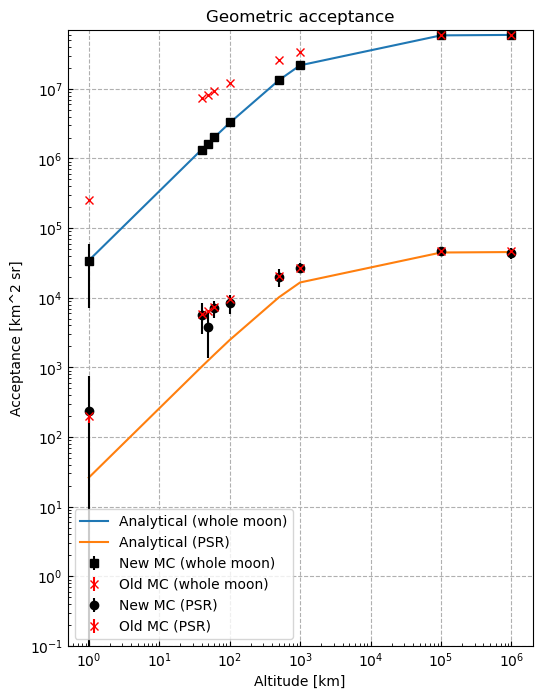

(0.1, 7.0e7)

In [14]:
using PyPlot

alts = ustrip.(altitudes)
accmoon = ustrip.([r[2] for r in results_moon])
errmoon = ustrip.([r[3] for r in results_moon])
accpsr = ustrip.([r[2] for r in results_psr])
errpsr = ustrip.([r[3] for r in results_psr])
oldacc = ustrip.([r[2] for r in results_old])
olderr = ustrip.([r[3] for r in results_old])

# Plot
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["axes.axisbelow"] = true
rcParams["axes.grid"] = true
rcParams["grid.linestyle"] = "dashed"
rcParams["xtick.direction"] = "in"
rcParams["ytick.direction"] = "in"

fig, axs = plt.subplots(1, 1, figsize=(6, 8))
axs.set_title("Geometric acceptance")
axs.loglog(alts, alex, label="Analytical (whole moon)")
axs.errorbar(alts, accmoon, errmoon, fmt="ks", label="New MC (whole moon)")
axs.errorbar(alts, oldacc*(4 * π * 1737.4^2 / 30000), olderr, fmt="rx", label="Old MC (whole moon)")
axs.loglog(alts, alex.*(2.8921e4 / (4 * π * 1737.4^2)), label="Analytical (PSR)")
axs.errorbar(alts, accpsr, errpsr, fmt="ko", label="New MC (PSR)")
axs.errorbar(alts, oldacc, olderr, fmt="rx", label="Old MC (PSR)")
axs.set_ylabel("Acceptance [km^2 sr]")
axs.legend()
axs.set_xlabel("Altitude [km]")
axs.set_ylim(1e-1, 7e7)
 

In [ ]:
# Number of trials and energy bins in each run
# ntrials = 1000  # Baseline test: 100_000
# nbins = 10  # Baseline test: 20
# altitude = 40km
# ice_depth = 20.0m
# trigger = magnitude_trigger(1e-5μV/m)
# A = old_acceptance(ntrials, nbins; altitude=altitude, ice_depth=ice_depth,min_energy=1.0EeV,ν_max=1000MHz,dν = 30MHz,trigger=trigger,save_events=false)
# B = acceptance(Int(1e4), nbins, altitude=altitude, region=WholeMoonRegion(), spacecraft=FixedPlatform(90.0,0.0), min_energy=1.0EeV, max_energy=600.0EeV)

In [ ]:
using BenchmarkTools

@btime A = acceptance(ntrials, nbins, region=PolarRegion(:south, 10), spacecraft=FixedPlatform(-90.0, 0.0, altitude), min_energy=1.0EeV, max_energy=600.0EeV)
@btime AO = old_acceptance(ntrials, nbins; altitude=altitude, ice_depth=ice_depth,min_energy=1.0EeV,ν_max=1000MHz,dν = 30MHz,trigger=trigger,save_events=false)
